In [ ]:
#!pip install finnhub-python

In [829]:
# import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn
import yfinance
import time
import finnhub
import re

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from pandas_datareader import data as pd_data
#from datetime import datetime

In [763]:
# load prices - get close price from yahoo finance
def load_prices(symbols, lookback_years, reset_index=0):
    """load prices of the symbols. Lookback period is in Months from today"""
    #symbols = sorted(symbols)
    
    start_date = (datetime.datetime.today() - datetime.timedelta(days=365*lookback_years)).date()
    end_date = datetime.datetime.today().date() - datetime.timedelta(days=1)
    
    prices = yfinance.download(symbols,
                               start = str(start_date),
                               end = str(end_date),
                               interval = '1d',
                               auto_adjust = True,
                               threads = True)
    
    try:
        cols = [('Close',x) for x in symbols]
        print(cols)
        data_fn = prices[cols]
        data_fn.columns = data_fn.columns.get_level_values(1)

        if reset_index == 1:
            data_fn.reset_index(level=0, inplace=True)
    except:
        return prices

    return data_fn

In [130]:
def compute_daily_return(df):
    """Compute and return the daily return values."""
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:] / df[:-1].values) - 1
    daily_returns.iloc[0, :] = 0
    return daily_returns

In [157]:
def compute_daily_log_return(df):
    """Compute and return the daily return values."""
    daily_log_returns = df.copy()
    daily_log_returns[1:] = np.log(df[1:] / df[:-1].values)
    daily_log_returns.iloc[0, :] = 0
    return daily_log_returns

In [704]:
def get_bithumb_daily_data(symbol, filter_start_date, filter_end_date):
    url = f"https://api.bithumb.com/public/candlestick/{symbol}/24h"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    print(response)

    # timestamp, open, close, high, low, volumn
    data = json.loads(response.text)
    df = pd.DataFrame(data['data'])
    df.columns = ['timestamp', 'open', 'close', 'high', 'low', 'volume']
    df['timestamp'] = df['timestamp'].map(convert_date_from_UNIX)
    df = df[ ( df['timestamp'] >= filter_start_date ) & ( df['timestamp'] <= filter_end_date )]
    return df

In [1226]:
def convert_date_from_UNIX_finnhub(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp).date().strftime("%Y-%m-%d")

In [1227]:
def convert_time_from_UNIX_finnhub(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp).time().strftime("%H-%M-%S")

In [ ]:
def convert_date_from_UNIX(unix_timestamp):
    return datetime.fromtimestamp(unix_timestamp/1000).date().strftime("%Y-%m-%d")

In [1025]:
def get_data_finnhub(symbol, start, end, freq):
    dt_start = datetime.datetime.strptime(start, '%Y-%m-%d')
    dt_end = datetime.datetime.strptime(end, '%Y-%m-%d')
    data = finnhub_client.crypto_candles(symbol, f'{freq}',
                                         int(datetime.datetime.timestamp(dt_start)),
                                         int(datetime.datetime.timestamp(dt_end)))
    df = pd.DataFrame(data)
    #df['t'] = df['t'].map(convert_date_from_UNIX_finnhub)
    df = df[['t','c','v']]
    df.columns = ['timestamp','close','volume']
    return df

In [1000]:
def normalize_data(df):
  """Normalize stock prices using the first row of the dataframe."""
  return df / df.iloc[0,:]

In [746]:
bithumb_krw = get_bithumb_daily_data('BTC_KRW', '2021-06-01', '2022-11-30')

<Response [200]>


In [747]:
bithumb_krw.head()

,timestamp,open,close,high,low,volume
2624,2021-06-01,43462000,43995000,44296000,42431000,3508.40066261
2625,2021-06-02,44000000,44911000,45657000,43422000,3728.04628466
2626,2021-06-03,44914000,43276000,45538000,42100000,4234.17012163
2627,2021-06-04,43303000,41987000,43803000,41500000,2900.827816065
2628,2021-06-05,41974000,42075000,42718000,41342000,2331.0141608


In [709]:
# Get finnhub Crypto Exchange List
finnhub_client = finnhub.Client(api_key="cdgrrlaad3i2r375fn5gcdgrrlaad3i2r375fn60")
FH_exchange_list = finnhub_client.crypto_exchanges()
FH_exchange_list

['BITMEX',
 'OKEX',
 'BITFINEX',
 'GEMINI',
 'BINANCEUS',
 'BINANCE',
 'KUCOIN',
 'HITBTC',
 'KRAKEN',
 'COINBASE',
 'HUOBI',
 'BITTREX',
 'POLONIEX',
 'FXPIG']

# Compare Normalized prices for Cross-exchange arbitrage opportunities

In [1208]:
coinbase_usd = get_data_finnhub('COINBASE:BTC-USDT', '2022-12-01', '2022-12-02', '1')
#coinbase_usd = coinbase_usd[coinbase_usd['timestamp'] > '2021-12-31']

In [1209]:
bittrex_usd = get_data_finnhub('BINANCE:BTCUSDT', '2022-12-01', '2022-12-02', '1')

In [1246]:
df_merged = coinbase_usd.merge(bittrex_usd, how='left', on='timestamp', suffixes=('_cb','_bt'))

In [1247]:
df_merged = df_merged.dropna(axis=0)

In [1248]:
df_merged.reset_index(inplace=True)

In [1249]:
df_merged.shape

(1216, 6)

In [1274]:
df_merged.head()

,index,timestamp,close_cb,volume_cb,close_bt,volume_bt,pvol_cb,pvol_bt,vwap_cb,vwap_bt
0,8,00-00-00,17138.83,0.867198,17139.92,60.46078,14862.755499,1.036293e+06,17138.830000,17139.920000
1,9,00-01-00,17143.91,1.083724,17145.69,162.89521,18579.268435,2.792951e+06,17141.651906,17144.128105
2,10,00-02-00,17137.57,0.530969,17139.58,109.27355,9099.521833,1.872903e+06,17140.778634,17142.633987
3,11,00-03-00,17130.04,1.951164,17130.85,173.34153,33423.517367,2.969488e+06,17136.052134,17138.596890
4,12,00-04-00,17134.49,0.607195,17132.51,83.08581,10403.981282,1.423468e+06,17135.863945,17137.738341


In [1251]:
df_merged['pvol_cb'] = df_merged['close_cb'] * df_merged['volume_cb']
df_merged['pvol_bt'] = df_merged['close_bt'] * df_merged['volume_bt']

In [1252]:
pvol = df_merged['pvol_cb']
vol = df_merged['volume_cb']

vwap = []
#vwap.append(df_merged['close_cb'][0])
for i in range(1,len(pvol)+1):
    vwap.append(sum(pvol[0:i])/sum(vol[0:i])) 

In [1253]:
df_merged['vwap_cb'] = vwap

In [1254]:
pvol = df_merged['pvol_bt']
vol = df_merged['volume_bt']

vwap = []
#vwap.append(df_merged['close_cb'][0])
for i in range(1,len(pvol)+1):
    vwap.append(sum(pvol[0:i])/sum(vol[0:i])) 

In [1255]:
df_merged['vwap_bt'] = vwap

In [1273]:
df_merged['timestamp'] = df_merged['timestamp'].map(convert_time_from_UNIX_finnhub)

In [1256]:
df_normalized = normalize_data(df_merged[['close_cb','close_bt']])

In [1621]:
x = df_normalized['timestamp']
y1 = df_normalized['close_cb']
y2 = df_normalized['close_bt']

In [1454]:
len(x)

1440

In [1464]:
from matplotlib.dates import DateFormatter

In [1482]:
plt.style.use('seaborn-v0_8-whitegrid')

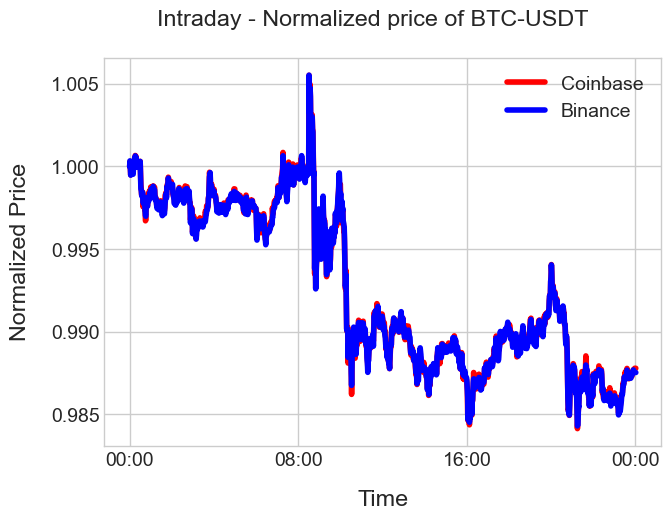

In [1623]:
fig, ax = plt.subplots()

ax.plot(x, y1, 'r')
ax.plot(x, y2, 'b')
fig.suptitle('Intraday - Normalized price of BTC-USDT')
ax.set_xlabel('Time', labelpad=15)
ax.set_ylabel('Normalized Price', labelpad=15)
ax.set_xticks(np.arange(0, 1440, 1438/3))

myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
ax.legend(['Coinbase','Binance'])
plt.show()

# Cointegraion model - Pairs Trading

In [1782]:
sym = ['ETH-USD', 'BTC-USD', 'XRP-USD', 'DOGE-USD', 'ADA-USD','SPY', 'SHY', 'BTC=F', 'LTC-USD']

In [1976]:
df = load_prices(sym, 3.5, 0)

[*********************100%***********************]  9 of 9 completed
[('Close', 'ETH-USD'), ('Close', 'BTC-USD'), ('Close', 'XRP-USD'), ('Close', 'DOGE-USD'), ('Close', 'ADA-USD'), ('Close', 'SPY'), ('Close', 'SHY'), ('Close', 'BTC=F'), ('Close', 'LTC-USD')]


In [1978]:
df_long_short = df.dropna(axis=0)

In [2036]:
df_long_short.head()

,ETH-USD,BTC-USD,XRP-USD,DOGE-USD,ADA-USD,SPY,SHY,BTC=F,LTC-USD
Date,,,,,,,,,
2019-06-13,256.168793,8230.923828,0.400887,0.003074,0.089739,273.366089,81.755852,8285.0,131.351761
2019-06-14,264.087463,8693.833008,0.405921,0.003124,0.090619,273.064087,81.726875,8440.0,133.053268
2019-06-17,274.351105,9320.352539,0.448080,0.003190,0.093557,273.167847,81.688225,9380.0,134.438095
2019-06-18,265.051849,9081.762695,0.428761,0.003125,0.089148,276.028229,81.697861,9115.0,135.158737
2019-06-19,269.431793,9273.521484,0.436817,0.003130,0.089979,276.651215,81.871788,9210.0,136.603195


In [1985]:
pair_one = df_long_short['ADA-USD'].values.reshape(-1,1)
pair_two = df_long_short['ETH-USD'].values.reshape(-1,1)

In [1986]:
log_one = np.log(pair_one) # ADA
log_two = np.log(pair_two) # ETH

In [1987]:
linear_reg = linear_model.LinearRegression()
linear_reg.fit(log_one, log_two)
prediction = linear_reg.predict(log_one)
residuals = log_two - prediction

In [1988]:
linear_reg.coef_, adfuller(residuals)[1]

(array([[0.80530693]]), 0.0340271467345527)

In [2011]:
coint_coeff = linear_reg.coef_
spread = log_two - coint_coeff * log_one
average_sp = np.mean(spread)
resid = spread - average_sp

In [2012]:
# Create X-axis
x = pd.to_datetime(df_long_short.index.values)
x_2 = [datetime.datetime.strftime(i, "%Y-%m-%d") for i in x]

In [2015]:
len(x_2)

881

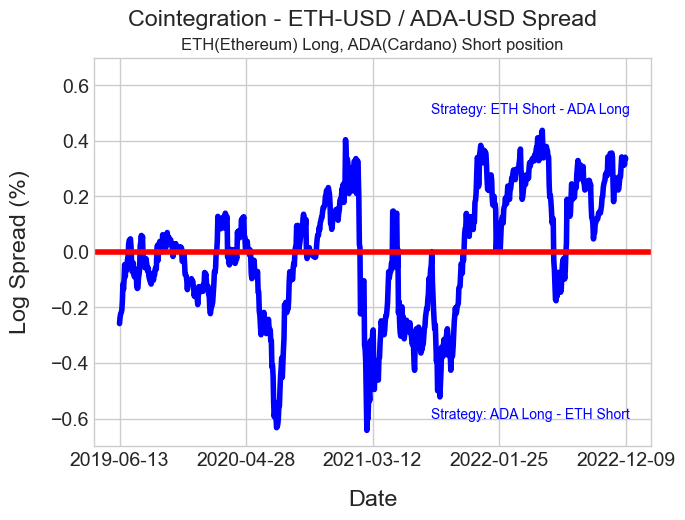

In [2035]:
# Plot Log-spread
fig, ax = plt.subplots()

ax.plot(x_2, resid, 'b')
plt.axhline(y=0, color = 'red')
plt.title('ETH(Ethereum) Long, ADA(Cardano) Short position', fontsize=12)
fig.suptitle('Cointegration - ETH-USD / ADA-USD Spread')
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Log Spread (%)', labelpad=15)
ax.set_xticks(np.arange(0, 881, 880/4))
#ax.annotate('LT Mean', xy = ('2022-04-20', -0.1), color='red', fontsize=15)
ax.annotate('Strategy: ETH Short - ADA Long', xy = ('2021-08-05', 0.5), color='blue', fontsize=10)
ax.annotate('Strategy: ADA Long - ETH Short', xy = ('2021-08-05', -0.6), color='blue', fontsize=10)
plt.ylim([-0.7,0.7])
plt.show()

In [1678]:
for i in range(len(coinbase)):
    if re.match(r"COINBASE XRP", coinbase[i]['description']):
        print(coinbase[i])

{'description': 'COINBASE XRP/EUR', 'displaySymbol': 'XRP/EUR', 'symbol': 'COINBASE:XRP-EUR'}
{'description': 'COINBASE XRP/BTC', 'displaySymbol': 'XRP/BTC', 'symbol': 'COINBASE:XRP-BTC'}
{'description': 'COINBASE XRP/GBP', 'displaySymbol': 'XRP/GBP', 'symbol': 'COINBASE:XRP-GBP'}
{'description': 'COINBASE XRP/USD', 'displaySymbol': 'XRP/USD', 'symbol': 'COINBASE:XRP-USD'}


In [771]:
coinbase = finnhub_client.crypto_symbols('COINBASE')

In [1089]:
for i in range(len(coinbase)):
    if re.match(r"COINBASE ADA", coinbase[i]['description']):
        print(coinbase[i])

{'description': 'COINBASE ADA/USDC', 'displaySymbol': 'ADA/USDC', 'symbol': 'COINBASE:ADA-USDC'}
{'description': 'COINBASE ADA/USDT', 'displaySymbol': 'ADA/USDT', 'symbol': 'COINBASE:ADA-USDT'}
{'description': 'COINBASE ADA/BTC', 'displaySymbol': 'ADA/BTC', 'symbol': 'COINBASE:ADA-BTC'}
{'description': 'COINBASE ADA/ETH', 'displaySymbol': 'ADA/ETH', 'symbol': 'COINBASE:ADA-ETH'}
{'description': 'COINBASE ADA/USD', 'displaySymbol': 'ADA/USD', 'symbol': 'COINBASE:ADA-USD'}
{'description': 'COINBASE ADA/EUR', 'displaySymbol': 'ADA/EUR', 'symbol': 'COINBASE:ADA-EUR'}
{'description': 'COINBASE ADA/GBP', 'displaySymbol': 'ADA/GBP', 'symbol': 'COINBASE:ADA-GBP'}


In [758]:
curr_sym = ['KRW=X']

In [764]:
usd_krw = load_prices(curr_sym, 2, 0)

[*********************100%***********************]  1 of 1 completed
[('Close', 'KRW=X')]


In [769]:
usd_krw['Close']

Date
2020-12-10    1086.359985
2020-12-11    1086.369995
2020-12-14    1091.579956
2020-12-15    1092.060059
2020-12-16    1088.209961
                 ...     
2022-12-05    1299.170044
2022-12-06    1304.369995
2022-12-07    1319.709961
2022-12-08    1314.099976
2022-12-09    1316.630005
Name: Close, Length: 522, dtype: float64

In [ ]:
    pair_one = test['ETH-USD'].values.reshape(-1,1)
    pair_two = test['XRP-USD'].values.reshape(-1,1)

In [404]:
sym = ['GM', 'ETH-USD', 'BTC-USD', 'XRP-USD', 'DOGE-USD', 'SPY', 'SHY', 'BTC=F']

In [464]:
test = load_prices(sym, 1, 0)

[*********************100%***********************]  8 of 8 completed
[('Close', 'BTC-USD'), ('Close', 'BTC=F'), ('Close', 'DOGE-USD'), ('Close', 'ETH-USD'), ('Close', 'GM'), ('Close', 'SHY'), ('Close', 'SPY'), ('Close', 'XRP-USD')]


In [406]:
test_log = compute_daily_log_return(test)

In [407]:
test_log.head()

,BTC-USD,BTC=F,DOGE-USD,ETH-USD,GM,SHY,SPY,XRP-USD
Date,,,,,,,,
2019-12-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-09,-0.021844,NaN,-0.013495,-0.020299,NaN,NaN,NaN,-0.021862
2019-12-10,-0.016729,-0.014448,-0.001813,-0.013299,-0.007661,-0.000472,-0.001116,-0.005114
2019-12-11,-0.008374,-0.005559,-0.008658,-0.018347,0.003696,0.000828,0.002835,-0.010077
2019-12-12,0.003555,0.012466,0.001372,0.013803,0.024111,-0.000945,0.008582,-0.009930


In [271]:
test

,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,SHY,SPY,XRP-USD
Date,,,,,,,
2021-12-07,579.689880,50700.085938,0.176805,4315.061523,84.587036,461.299622,0.818588
2021-12-08,607.592773,50504.796875,0.179151,4439.357910,84.616707,462.521088,0.863307
2021-12-09,571.648987,47672.121094,0.169484,4119.815918,84.587036,459.398346,0.861272
2021-12-10,552.966858,47243.304688,0.164422,3908.496094,84.626602,463.722900,0.801097
2021-12-11,564.322510,49362.507812,0.169019,4084.452393,NaN,NaN,0.839313
...,...,...,...,...,...,...,...
2022-12-02,293.527496,17088.660156,0.102148,1294.303345,81.410004,406.910004,0.396273
2022-12-03,290.563141,16908.236328,0.099824,1243.334839,NaN,NaN,0.388147
2022-12-04,292.288300,17130.486328,0.104286,1280.256592,NaN,NaN,0.390735


In [224]:
np.log(47672.121094/50504.796875)

-0.057721555803232245

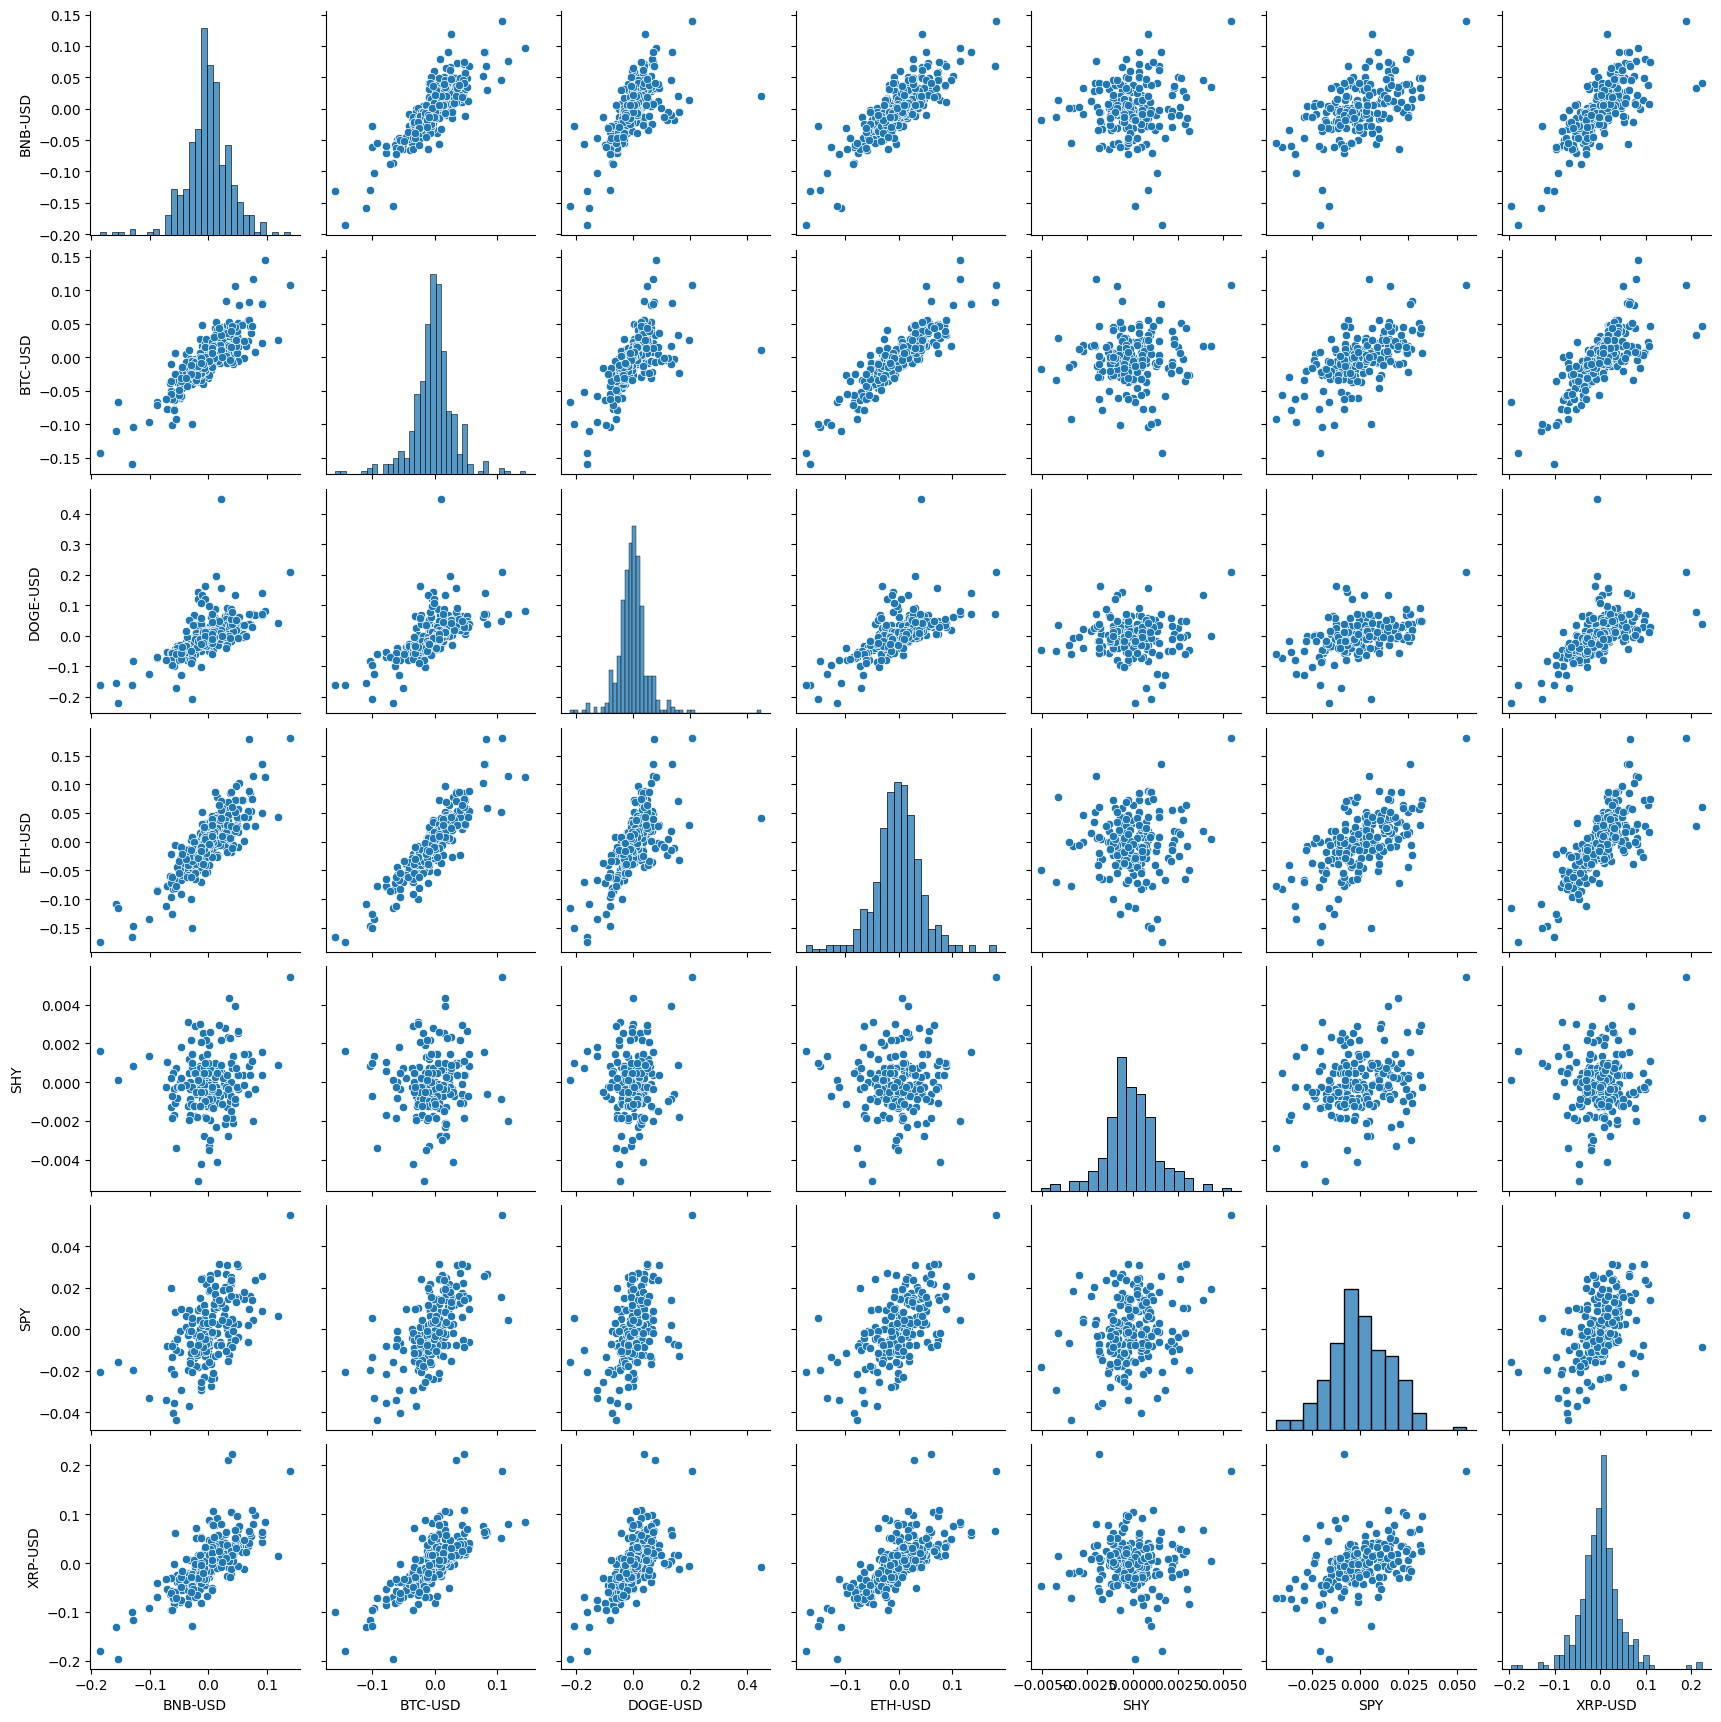

In [225]:
seaborn.pairplot(test_daily_return)
plt.show()

In [821]:
pd_data.get_quote_yahoo('AAPL')['marketCap']

AAPL    2261495578624
Name: marketCap, dtype: int64

In [822]:
test.columns.get_level_values(1)

IndexError: Too many levels: Index has only 1 level, not 2

In [465]:
test = test.dropna(axis=0)

In [493]:
pair_one = test['ETH-USD'].values.reshape(-1,1)

In [494]:
pair_two = test['XRP-USD'].values.reshape(-1,1)

In [495]:
linear_reg = linear_model.LinearRegression()

In [496]:
linear_reg.fit(pair_one, pair_two)

LinearRegression()

In [497]:
linear_reg.coef_

array([[0.00020303]])

In [498]:
prediction = linear_reg.predict(pair_one)

In [499]:
residuals = pair_two - prediction

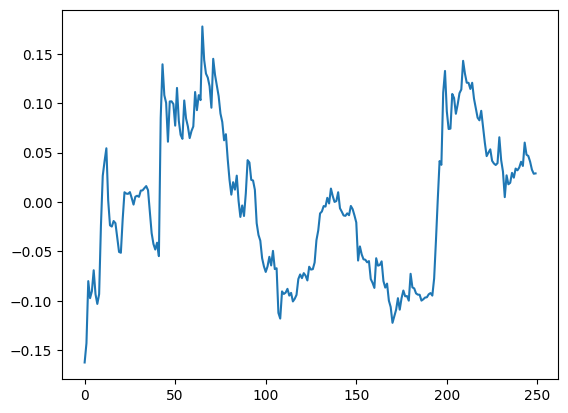

0.06430075216536238

In [505]:
log_one[:10]

array([[8.36986686],
       [8.39826503],
       [8.32356376],
       [8.27090795],
       [8.23859687],
       [8.22829449],
       [8.29863627],
       [8.28462278],
       [8.2634581 ],
       [8.27737247]])

In [506]:

log_two[:10]

array([[-0.20017435],
       [-0.14698492],
       [-0.14934494],
       [-0.22177327],
       [-0.24475795],
       [-0.22784336],
       [-0.18942953],
       [-0.21538621],
       [-0.22403018],
       [-0.12802887]])

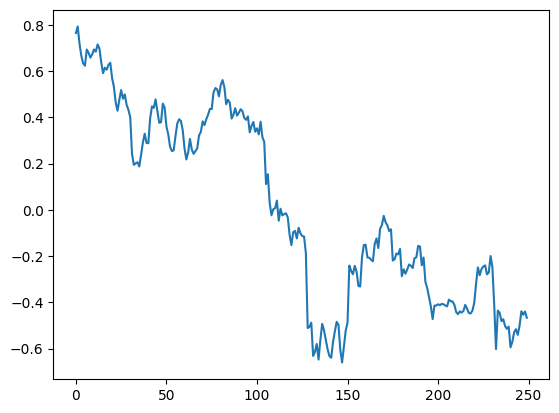

In [517]:
import statsmodels.tsa.stattools as ts 
result=ts.coint(pair_one, pair_two)
result

(-3.1051563154048423,
 0.08727186213277083,
 array([-3.94096428, -3.3607786 , -3.0615268 ]))

In [518]:
import statsmodels.tsa.stattools as ts 
result=ts.coint(pair_two, pair_one)
result

(-2.7640265047878967,
 0.1773993710009703,
 array([-3.94096428, -3.3607786 , -3.0615268 ]))

In [519]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen(test,0,1)

In [521]:
coint_johansen(test,0,1).eig

array([0.36014315, 0.14195514, 0.10813714, 0.07097327, 0.04437659,
       0.03011754, 0.02411917, 0.00993032])

['BITTREX', 'HUOBI', 'KRAKEN', 'COINBASE', 'BITFINEX', 'BINANCE', 'KUCOIN', 'HITBTC', 'POLONIEX', 'BINANCEUS', 'FXPIG', 'BITMEX', 'OKEX', 'GEMINI']


In [530]:
yfinance.download('BTC-USD',
                   start = "2020-01-01",
                   end = "2020-12-31",
                   interval = '1d',
                   auto_adjust = True,
                   threads = True)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095
...,...,...,...,...,...
2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922,66479895605
2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,49056742893
2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500,45265946774


{'c': [9518.04, 9666.24, 9789.06, 9621.16, 9666.3, 9746.99, 9782.01, 9772.43, 9885, 9280.4], 'h': [10228.99, 9690, 9881.63, 9854.75, 9735, 9802, 9800, 9877, 9992.72, 9964], 'l': [9266, 9365.21, 9450, 9581, 9531.05, 9372.46, 9633, 9570, 9704.18, 9113], 'o': [10202.71, 9518.02, 9666.32, 9788.14, 9621.17, 9666.85, 9746.99, 9782, 9772.44, 9885.22], 's': 'ok', 't': [1591056000, 1591142400, 1591228800, 1591315200, 1591401600, 1591488000, 1591574400, 1591660800, 1591747200, 1591833600], 'v': [108970.773151, 46252.644939, 57456.100969, 47788.05005, 32752.950893, 57952.848385, 40664.664125, 46024.001289, 47130.762982, 94418.98473]}


In [533]:
datetime.fromtimestamp(1590988249)

datetime.datetime(2020, 6, 1, 1, 10, 49)

In [566]:
datetime.fromtimestamp(1388070000)

datetime.datetime(2013, 12, 26, 10, 0)

In [560]:
datetime.timestamp(dt)

1591416000.0

In [552]:
dt = datetime.strptime('2020-06-01 01:10:49', '%Y-%m-%d %H:%M:%S')

1590988249.0

In [563]:
binance_symbol = finnhub_client.crypto_symbols('BINANCE')

In [579]:
import requests
import json

In [573]:
url = "https://api.bithumb.com/public/candlestick/BTC_KRW/24h"
headers = {"accept": "application/json"}
response = requests.get(url, headers=headers)

# timestamp, open, close, high, low, volumn
data = json.loads(response.text)

In [592]:
df = pd.DataFrame(data['data'])
df.columns = ['timestamp',
              'open',
              'close',
              'high',
              'low',
              'volumn']

In [620]:
def convert_date_from_UNIX(unix_timestamp):
    return datetime.fromtimestamp(unix_timestamp/1000).date().strftime("%Y-%m-%d")

In [617]:
df.head()

,timestamp,open,close,high,low,volumn
0,1388070000000,737000,755000,755000,737000,3.78
1,1388156400000,750000,750000,750000,750000,12
2,1388242800000,750000,739000,750000,728000,19.058
3,1388329200000,740000,768000,772000,740000,9.488973
4,1388415600000,768000,768000,800000,763000,18.65035033


In [623]:
df['timestamp'] = df['timestamp'].map(convert_date_from_UNIX)

In [641]:
test = get_bithum_daily_data('ETH_KRW')

<Response [200]>


In [653]:
test.head()

,timestamp,open,close,high,low,volumn
0,2016-09-28,14700,14500,14800,14500,14.46754379
1,2016-09-29,14500,14900,14900,14500,204.66000817
2,2016-09-30,14900,14500,14900,14500,946.0951
3,2016-10-01,14600,14600,14600,14600,.193
4,2016-10-02,14700,14600,14700,14600,3.5476


In [655]:
test2 = test[(test['timestamp'] >= '2021-01-01') & (test['timestamp'] <= '2022-11-31')]

In [656]:
test2.head()

,timestamp,open,close,high,low,volumn
1553,2021-01-01,811500,835500,851000,790000,92823.483995020525600442
1554,2021-01-02,835500,1026000,1059000,834000,235579.647892395724404709
1555,2021-01-03,1026000,1190000,1335000,970000,692829.227353538789790624
1556,2021-01-04,1189000,1185000,1291000,1116000,389703.092105148295964957
1557,2021-01-05,1185000,1263000,1320000,1170000,330430.999532889099466939


In [657]:
test2.tail()

,timestamp,open,close,high,low,volumn
2247,2022-11-26,1668000,1662000,1677000,1650000,14923.453727578452312004
2248,2022-11-27,1662000,1612000,1674000,1606000,28685.735643560709518273
2249,2022-11-28,1611000,1652000,1670000,1595000,17090.075022152765300624
2250,2022-11-29,1650000,1714000,1737000,1648000,18641.268260553734754493
2251,2022-11-30,1714000,1730000,1767000,1709000,18319.628950081084842125
